In [1]:
# main libraries for data processing/plotting
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
import seaborn as sns

# import torch functionality
import torch
from torch.utils.data import DataLoader, TensorDataset

# import flower modules
import flwr as fl
from flwr.server.strategy import FedAvg

# import custom modules
from fedtabdiff_modules import init_model
from FlowerClient import get_client_fn, get_eval_config
from FlowerServer import get_evaluate_server_fn
from utils import get_parameters

%load_ext autoreload
%autoreload 2

Set parameters and seed

In [2]:
# define global experiment parameters
exp_params = dict(

    seed = 111, # random seed
    batch_size = 512, # batch size   
    n_cat_emb = 2, # size of the categorical embeddings (2 means each attribute will be 2-dimensional)
    learning_rate = 1e-4, # learning rate

    mlp_layers = [512, 512], # total neurons at each hidden feed-forward layer
    activation = 'lrelu', # activation function

    # diffusion parameters
    diffusion_steps = 500,  # number of diffusion steps
    diffusion_beta_start = 1e-4, # initial value of beta
    diffusion_beta_end = 0.02, # final value of beta
    scheduler = 'linear', # linear or quad

    # federated parameters
    server_rounds = 100, # number of server rounds
    client_rounds = 5, # number of client rounds
    n_clients = 5, # number of clients
    fraction_fit = 1.0, # fraction of clients used for training
    fraction_evaluate=1.0, # fraction of clients used for evaluation
    min_fit_clients=5, # minimum number of clients used for training
    min_evaluate_clients=1, # minimum number of clients used for evaluation

    # evaluation periods
    eval_rate_server = 10, # evaluate server every n rounds
    eval_rate_client = 100, # evaluate client every n rounds

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
)
    
# set seed
rng = np.random.default_rng(exp_params['seed']) # set numpy seed
torch.manual_seed(exp_params['seed'])  # set pytorch seed CPU
torch.cuda.manual_seed(exp_params['seed'])  # set pytorch seed GPU

# Load and preprocess dataset
The City of Philadelphia Payments is used for showing the technique. The dataset can be accessed under the following link: https://www.phila.gov/2019-03-29-philadelphias-initial-release-of-city-payments-data 

In [3]:
# read csv file
train_raw = pd.read_csv(r'data/city_payments_fy2017.csv.zip')

# remove underscore in column names for correct inverse decoding
train_raw.columns = [col.replace('_', ' ') for col in train_raw.columns]

# identify numeric and categorical attributes
cat_attrs = ['fm', 'check date', 'department title', 'character title', 'sub obj title', 'vendor name', 'contract description']
num_attrs = ['transaction amount']

# extract label
label_name = 'doc ref no prefix definition'
label = train_raw[label_name]

# take subset of top 5 most frequent label values
top_n = train_raw[label_name].value_counts().nlargest(5).index
train_raw = train_raw[train_raw[label_name].isin(top_n)].reset_index(drop=True)

# add col name to every entry to make them distinguishable for embedding
for cat_attr in cat_attrs:
    train_raw[cat_attr] = cat_attr + '_' + train_raw[cat_attr].astype('str')

# extract and transform label
label = train_raw[label_name].fillna('NA')
class_encoder = LabelEncoder().fit(label)
label = class_encoder.transform(label)

In [4]:
# take cat and num subsets
train = train_raw[[*cat_attrs, *num_attrs]]

# update categorical attributes
train[cat_attrs] = train[cat_attrs].astype(str)

print('Processed data: Train shape: {}'.format(train.shape))

Processed data: Train shape: (215302, 8)


/var/folders/hr/9sd04tdn71vf50y_zyl5j5g40000gn/T/ipykernel_5688/862577455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[cat_attrs] = train[cat_attrs].astype(str)


In [5]:
### transform numeric attributes
num_scaler = QuantileTransformer(output_distribution='normal', random_state=exp_params['seed'])
num_scaler.fit(train[num_attrs])
train_num_scaled = num_scaler.transform(train[num_attrs])

### transform categorical attributes
# get unique vocabulary values
vocabulary_classes = np.unique(train[cat_attrs])
# fit label encoder
label_encoder = LabelEncoder().fit(vocabulary_classes)
# transform dataset
train_cat_scaled = train[cat_attrs].apply(label_encoder.transform)
# collect unique categories of each attribute
vocab_per_attr = {cat_attr: set(train_cat_scaled[cat_attr]) for cat_attr in cat_attrs}

# add processed data parameters to experiment parameters
exp_params['n_cat_tokens'] = len(vocabulary_classes)
exp_params['n_classes'] = len(np.unique(label))
exp_params['cat_dim'] = exp_params['n_cat_emb'] * len(cat_attrs)
exp_params['encoded_dim'] = exp_params['cat_dim'] + len(num_attrs)
exp_params['vocab_per_attr'] = vocab_per_attr
exp_params['num_scaler'] = num_scaler
exp_params['num_attrs'] = num_attrs
exp_params['cat_attrs'] = cat_attrs
exp_params['label_encoder'] = label_encoder

# init torch tensors
train_num_torch = torch.FloatTensor(train_num_scaled)
train_cat_torch = torch.LongTensor(train_cat_scaled.values)
label_torch = torch.LongTensor(label)

print('Encoded categorical data: Train shape: {}'.format(train_cat_torch.shape))
print('Encoded numerical data: Train shape: {}'.format(train_num_torch.shape))

Encoded categorical data: Train shape: torch.Size([215302, 7])
Encoded numerical data: Train shape: torch.Size([215302, 1])


### Split preprocessed dataset into train and test data loaders. In addition, every data loader contains multiple non-overlaping data partitions. The data is partitioned according to a selected label. Each partition will be assigned to individual client during training. Such scheme simulates the non-iid data split.

In [6]:
# collect list of indices based on label (non-iid splits)
unique_keys = np.unique(label)
data_split_mapping = {k: np.argwhere(label == k).squeeze() for k in unique_keys}

# split train, test and label sets
train_loaders_client = []
test_loaders_client = []
test_loader_server = (train, label_torch) # here the complete train set is used to evaluate on the entire population distribution

for indices in data_split_mapping.values():

    # pack train partitiones into TensorDataset
    train_set = TensorDataset(
        train_cat_torch[indices],        
        train_num_torch[indices],
        label_torch[indices]
        )

    # pack test partitiones 
    test_set = (
       train.iloc[indices], 
       label_torch[indices]
    )

    # append train and test loaders
    train_loaders_client.append(DataLoader(train_set, batch_size=exp_params['batch_size'], shuffle=True))
    test_loaders_client.append(test_set)

# Initialize synthesizer (FinDiff) and flower client/server functions

In [7]:
# init synthesizer and diffuser
synthesizer, diffuser = init_model(exp_params=exp_params)

# Get the initialized model parameters
init_params = get_parameters(synthesizer)

# define client function. It will be called by the VirtualClientEngine whenever a client is sampled by the strategy to participate.
client_fn = get_client_fn(
    train_loaders=train_loaders_client,
    test_loaders=test_loaders_client,
    exp_params=exp_params
)

# define server function for evaluation of entire population. It will be called at every training round.
evaluate_server_fn = get_evaluate_server_fn(
    test_loader=test_loader_server,
    exp_params=exp_params
)

# function used to configure training. We use it to append global experiment parameters to the training config. 
evaluate_client_fn = get_eval_config(exp_params=exp_params)

# init strategy parameters
strategy_params = dict(
    fraction_fit=exp_params['fraction_fit'],
    fraction_evaluate=exp_params['fraction_evaluate'],
    min_fit_clients=exp_params['min_fit_clients'],
    min_evaluate_clients=exp_params['min_evaluate_clients'],
    min_available_clients=exp_params['n_clients'],
    initial_parameters=fl.common.ndarrays_to_parameters(init_params),
    evaluate_fn=evaluate_server_fn,
    on_fit_config_fn=evaluate_client_fn,
    on_evaluate_config_fn=evaluate_client_fn
)
strategy = FedAvg(**strategy_params) # FedAvg is the default strategy

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if exp_params['device'].type == 'cuda':
    client_resources = {"num_gpus": 1, "num_cpus": 4}


Initializing FedTabDiff model


In [ ]:
# Start simulation
hist = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=exp_params['n_clients'],
    config=fl.server.ServerConfig(num_rounds=exp_params['server_rounds']),
    strategy=strategy,
    client_resources=client_resources
)

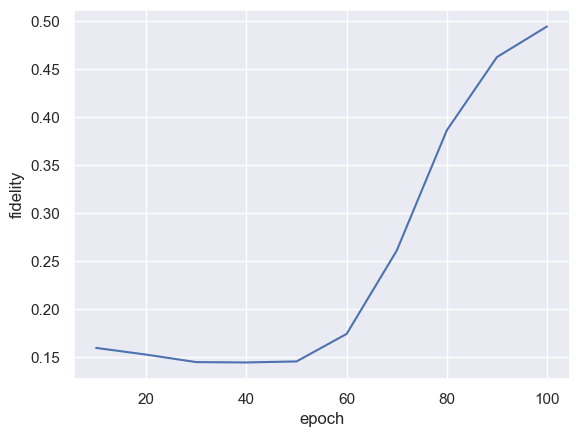

In [10]:
# plot fidelity scores
sns.set_theme(style="darkgrid")
plot_df = pd.DataFrame(hist.metrics_centralized['fidelity'], 
                       columns=['epoch', 'fidelity'])
sns.lineplot(data=plot_df, x='epoch', y='fidelity');